In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import rasterio as rio
from rasterio import CRS
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio.plot import show_hist
import tensorflow as tf
import keras
from keras import models, layers, utils, backend as K
import shap

from functions import one_hot_encode, preprocess, binary_classification_preprocess, multiclass_classification_preprocess, nn_regression_preprocess
from functions import linear_regression, logistic_regression, decision_tree, random_forest, neural_net
from neural_net_functions import DNN_functional, get_compiled_model, dense_block, run_training, neural_net, nn_regression_preprocess

In [15]:
# reads a portion of raster
def read_image_chunk(path, xgeo, ygeo, width, height):
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(window=rio.windows.Window(col, row, width, height))
    return data

In [27]:
features = get_features(linear_regression)
meta, df = get_input_df(linear_regression, features)

       landsat_1  landsat_2  landsat_3  landsat_4  landsat_5  landsat_6  \
0            222        375        202       3397       1468        540   
1            234        402        225       3310       1531        585   
2            214        405        231       3238       1607        628   
3            225        388        216       3118       1461        553   
4            214        401        204       3391       1537        575   
...          ...        ...        ...        ...        ...        ...   
39995        208        494        294       3324       1413        680   
39996        162        413        232       2998       1104        475   
39997        150        346        202       2322        952        403   
39998        158        348        196       2858       1214        478   
39999        179        376        211       3226       1365        529   

       aspect_1_0  aspect_1_1  aspect_1_2  aspect_1_3  ...  wetlands_1_0  \
0             0.0      

In [26]:
# reads all files and adds each band/window of 200x200 to images array
paths = ['data/geoKARMA_h24v13_landsat_2019.tif',
    'data/geoKARMA_h24v13_aspect_2019.tif',
    'data/geoKARMA_h24v13_dem_2019.tif',
    'data/geoKARMA_h24v13_posidex_2019.tif', 
    'data/geoKARMA_h24v13_wetlands_2019.tif',
    'data/geoKARMA_h24v13_impervious_2019.tif']
training_dataset = './data/geoKARMA_h24v13_pixelbased_dataset.csv'


#opens and read paths into one array images
def open_paths():
    with rio.open(paths[0]) as src0:
        meta = src0.meta

    datas = {path.split('_')[-2]: read_image_chunk(path, 1034415, 1364805, 201, 201) for path in paths}
    images = pd.DataFrame(np.concatenate([datas[key] for key in ['landsat', 'dem', 'aspect', 'posidex', 'wetlands', 'impervious']]).reshape(11, -1).transpose(), columns=['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 
                                                                                                        'landsat_6', 'dem_1', 'aspect_1', 'posidex_1', 'wetlands_1', 'impervious_1'])
    return meta, images

# define features based on regression model
def get_features(pred_function):
    if pred_function == linear_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1']
    if pred_function == logistic_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']
    if pred_function == decision_tree or pred_function == random_forest:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']

    if pred_function == neural_net:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1', 'NDVI']
    return features

def get_input_df(pred_function, features):
    meta, images = open_paths()
    # creates dataframe from images array
    if pred_function == neural_net: data = nn_regression_preprocess(images)[features]
    else: data = preprocess(images)[features]
    print(data)
    #df = data[features]
    return meta, data

def get_predictions(input_df, model):
    df = input_df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)
    return df

def write_raster(meta, array, new_name):
    with rio.open(new_name, 'w',
        driver='GTiff',
        dtype=np.uint16,
        width=200,
        height=200,
        count=1,
        crs=meta['crs'],
        compress='lzw',
        transform=meta['transform']) as output:
            output.write(array)

def map_impervious(pred_function, new_name):
    # define features and input
    features = get_features(pred_function)
    meta, df = get_input_df(pred_function, features)

    # gets the regression model trained on full csv dataset
    #get predictions for input
    if pred_function == neural_net:
        model = tf.keras.models.load_model("./data/model.h5", compile=False)
        impervious_df = model.predict_on_batch(df)
    elif pred_function == decision_tree:
        model = pred_function(training_dataset, 5)
        impervious_df = df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)
    else:
        model = pred_function(training_dataset)
        impervious_df = df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)

    # reshapes output into 200x200 array
    impervious_output = np.array(impervious_df).reshape(1, 200, 200)
    impervious_output = np.transpose(impervious_output, (0,2,1))
    
    #write new raster
    write_raster(meta, impervious_output, new_name)
    

In [4]:
# options for model: linear_regression, logistic_regression, decision_tree, neural_net

map_impervious(neural_net, 'new_dnn5.tif')

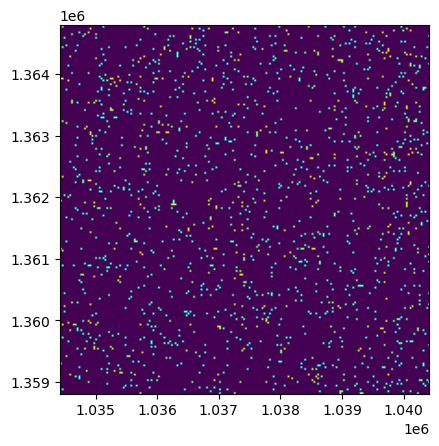

<Axes: >

In [5]:
raster = rio.open('new_dnn5.tif')
show(raster)